# Post-WTMM analysis of terminus positions

By Jukes Liu (jukesliu@boisestate.edu)

_Last modified 06-12-2020._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import subprocess
import fiona
from shapely.geometry import Polygon, Point
import shapely
import cv2


basepath = '/home/jukes/Documents/Sample_glaciers/'

os.chdir('/home/jukes/automated-glacier-terminus')
from automated_terminus_functions import midpoint

### Grab the BoxIDs

In [14]:
velocities_df = pd.read_csv(basepath+'Glacier_vel_measures_SE_2.csv', sep=',', dtype=str)
velocities_df = velocities_df.set_index('BoxID')
velocities_df = velocities_df.drop(['259', '115']) # DROP THESE
BoxIDs = list(velocities_df.index)
BoxIDs = BoxIDs[-7:]
print(BoxIDs)

['229', '235', '247', '253', '271', '277', '295']


In [9]:
# downloaded_df = pd.read_csv(basepath+'Boxes_coords_pathrows_SE_1.csv', sep=',', dtype=str)
# downloaded_df = downloaded_df.set_index('BoxID')
# downloaded_df = downloaded_df.drop(['281', '215', '245', '269', '287', '221', '185', '275', '293'])
# downloaded_df
# # change filename as desired
# CLINE_NAME = 'Boxes_coords_pathrows_SE_1.csv'
# downloaded_df.to_csv(path_or_buf = basepath+CLINE_NAME, sep=',')

# 1) Grab the vertices of the glacier terminus boxes in pixel coordinates

The vertices of the glacier terminus box will be used to calculate a midpoint of the left edge of the terminus box, which will be our reference point for calculating terminus position. Grab the minimum box dimension from the buffer distance csv:

In [15]:
dim_df = pd.read_csv(basepath+'Buffdist_SE_2.csv', sep=',', dtype=str)
dim_df = dim_df.set_index('BoxID')
dim_df

,Unnamed: 0,Buff_dist_m,min_dim_px
BoxID,,,
067,0,1648,54
073,1,1261,63
079,2,861,33
085,3,614,23
091,4,1104,40
097,5,930,41
103,6,907,30
109,7,810,21
115,8,2301,73


## Method 1: Use cv2 corner finding algorithms

229


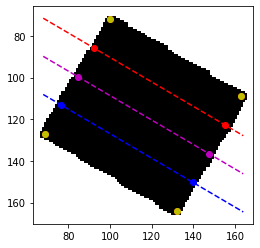

235


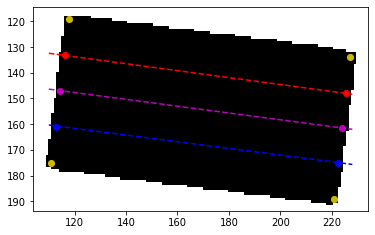

247


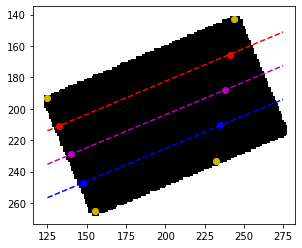

253


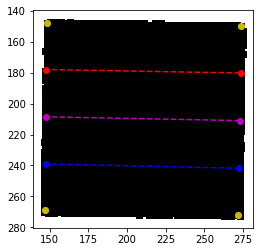

271


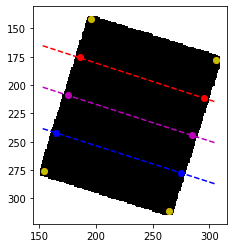

277


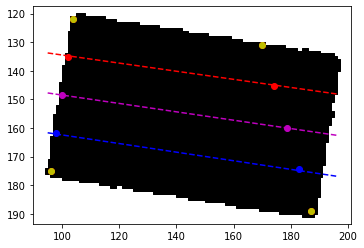

295


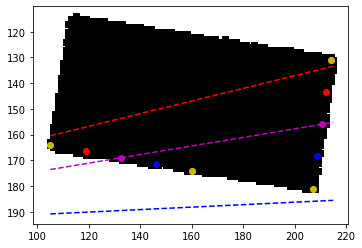

,lmid50_x,lmid50_y,rmid50_x,rmid50_y,m50,b50,lmid25_x,lmid25_y,rmid25_x,rmid25_y,m25,b25,lmid75_x,lmid75_y,rmid75_x,rmid75_y,m75,b75
BoxID,,,,,,,,,,,,,,,,,,
229,84.5,99.5,147.5,136.5,0.587302,49.873016,92.25,85.75,155.25,122.75,0.587302,31.571429,76.75,113.25,139.75,150.25,0.587302,68.174603
235,114.5,147.0,224.0,161.5,0.132420,131.837900,116.25,133.00,225.50,147.75,0.135011,117.606164,112.75,161.00,222.50,175.25,0.129841,146.069635
247,140.0,229.0,238.0,188.0,-0.418367,287.571429,132.50,211.00,241.00,165.50,-0.419355,266.433673,147.50,247.00,235.00,210.50,-0.417143,308.709184
253,147.5,208.5,273.0,211.0,0.019920,205.561753,147.75,178.25,273.50,180.50,0.017893,175.306773,147.25,238.75,272.50,241.50,0.021956,235.816733
271,175.0,209.0,285.0,244.5,0.322727,152.522727,185.50,175.50,295.50,211.25,0.325000,115.634091,164.50,242.50,274.50,277.75,0.320455,189.411364
277,100.0,148.5,178.5,160.0,0.146497,133.850318,102.00,135.25,174.25,145.50,0.141869,120.307325,98.00,161.75,182.75,174.50,0.150442,147.393312
295,132.5,169.0,210.5,156.0,-0.166667,191.083333,118.75,166.50,212.25,143.50,-0.245989,186.291667,146.25,171.50,208.75,168.50,-0.048000,195.875000


In [16]:
# create dictionary to store each terminus box ndarray by BoxID
termboxes2 = {}
  
# Create dictionaries and lists to store coordinates
topleft_coords = {}; bottomleft_coords = {}; topright_coords = {} ;bottomright_coords = {}
#create lists to store the left midpoints (1C) and right midpoints (2C)
midpoints_x = []; midpoints_y = []; midpoints_r_x = []; midpoints_r_y = []
mids_l025_x = []; mids_l025_y = []; mids_r025_x = []; mids_r025_y = []
mids_l075_x = []; mids_l075_y = []; mids_r075_x = []; mids_r075_y = []
#create lists to store the slopes and intercepts of the centerline equations
slope_50 = []; intercept_50 = []; slope_25 = []; intercept_25 = []; slope_75 = []; intercept_75 = []; boxes = []

# read in the terminus box rasters
for BoxID in BoxIDs:
    # load in the raster
#     boxpath = basepath+"Box"+BoxID+"/rotated_images/final/crop_Box"+BoxID+"_raster_cut.pgm"
    boxpath = "/media/jukes/jukes1/LS8aws/Box"+BoxID+"/rotated_c1/R_Box"+BoxID+"_raster_cut.png"
    # read the raster into an ndarray
    termbox = cv2.imread(boxpath)
    termbox = cv2.cvtColor(termbox, cv2.COLOR_BGR2GRAY)
    
    # create dictionary to store the all coordinates of the box rasters
    boxes_xcoords = {}; boxes_ycoords = {}
    
    # grab x and y coordinates
    BOI = termbox
    if len(BOI.shape) > 2:
        yindices, xindices, third= np.where(BOI > 0) #keep the pixels of where the box exists
    else:
        yindices, xindices= np.where(BOI > 0) #keep the pixels of where the box exists
    boxes_ycoords.update( {BoxID: yindices}); boxes_xcoords.update( {BoxID: xindices}) #add box coordinates to the dictionary
    
    # grab 0.95*minimum dimension as minimum distance between corners
    min_dist = 0.9*int(dim_df.loc[BoxID]['min_dim_px'])
    
    # FIND CORNERS:
    quality = 0.1
    corners = cv2.goodFeaturesToTrack(termbox,4,quality,min_dist)
    
    cornerxs = []; cornerys = []
    for i in range(0, 4):
        cornerxs.append(corners[i][0][0]); cornerys.append(corners[i][0][1])
    cornerxs = np.array(cornerxs); cornerys = np.array(cornerys)
    
    # FIND THE TWO LEFT COORDINATES:
    # two minimum x values:
    [x1,x2] = np.sort(cornerxs)[:2]
    if x1 == x2:
        print('Two of the same x coordinates, with y:', np.where(cornerxs == x1)[0])
        [x1_i, x2_i] = np.where(cornerxs == x1)[0]
    else:
        x1_i = np.where(cornerxs == x1)[0][0]; x2_i = np.where(cornerxs == x2)[0][0]
    # pair the x and y
    coord1 = [x1, cornerys[x1_i]]; coord2 = [x2,cornerys[x2_i]]
    [ytopleft, ybottomleft] = np.sort([cornerys[x1_i], cornerys[x2_i]])
    for coord in [coord1, coord2]:
        if coord[1] == ytopleft:
            topleft = coord
        elif coord[1] == ybottomleft:
            bottomleft = coord
    
    # FIND THE TWO RIGHT COORDINATES
    [x3,x4] = np.sort(cornerxs)[2:]
    if x3 == x4:
        print('Two of the same x coordinates, with y:', np.where(cornerxs == x3)[0])
        [x3_i, x4_i] = np.where(cornerxs == x3)[0]
    else:
        x3_i = np.where(cornerxs == x3)[0][0]; x4_i = np.where(cornerxs == x4)[0][0]
    # pair the x and y
    coord3 = [x3, cornerys[x3_i]]; coord4 = [x4,cornerys[x4_i]]
    [ytopright, ybottomright] = np.sort([cornerys[x3_i], cornerys[x4_i]])
    for coord in [coord3, coord4]:
        if coord[1] == ytopright:
            topright = coord
        elif coord[1] == ybottomright:
            bottomright= coord
    
    topleft_coords.update(  {BoxID: topleft}  )     #Add to dictionary of topleft coordinates
    bottomright_coords.update( {BoxID: bottomright})
    bottomleft_coords.update( {BoxID: bottomleft}  ) #Add to dictionary of bottomleft coordinates
    topright_coords.update( {BoxID: topright} )
    
    # 1C and 2C) CALCULATE THE MIDPOINTS USING MIDPOINT FUNCTION
    midpoint_x, midpoint_y = midpoint(topleft[0], topleft[1], bottomleft[0], bottomleft[1])
    midpoint_r_x, midpoint_r_y = midpoint(topright[0], topright[1], bottomright[0], bottomright[1])
    # GRAB 1/4th and 3/4ths lines (midpoints)
    mid_l025_x, mid_l025_y = midpoint(topleft[0], topleft[1], midpoint_x, midpoint_y)
    mid_r025_x, mid_r025_y = midpoint(topright[0], topright[1], midpoint_r_x, midpoint_r_y) 
    mid_l075_x, mid_l075_y = midpoint(bottomleft[0], bottomleft[1], midpoint_x, midpoint_y)
    mid_r075_x, mid_r075_y = midpoint(bottomright[0], bottomright[1], midpoint_r_x, midpoint_r_y)
    
    # 3) CALCULATE CENTERLINE EQUATIONS (y_intercept = y1 - m*x1)
    m = (midpoint_r_y - midpoint_y)/(midpoint_r_x - midpoint_x);b = midpoint_y - (m*midpoint_x)
    m025 = (mid_r025_y-mid_l025_y)/(mid_r025_x-mid_l025_x); b025 = mid_l025_y - (m*mid_l025_x)
    m075 = (mid_r075_y-mid_l075_y)/(mid_r075_x-mid_l075_x); b075 = mid_l075_y - (m*mid_l075_x)
    
    # append BoxIDs, slopes, intercepts, midpoints, and centerlines to lists
    boxes.append(BoxID);
    midpoints_x.append(midpoint_x); midpoints_y.append(midpoint_y)
    midpoints_r_x.append(midpoint_r_x); midpoints_r_y.append(midpoint_r_y)  
    mids_l025_x.append(mid_l025_x); mids_l025_y.append(mid_l025_y); 
    mids_r025_x.append(mid_r025_x); mids_r025_y.append(mid_r025_y)
    mids_l075_x.append(mid_l075_x) ;mids_l075_y.append(mid_l075_y) ;
    mids_r075_x.append(mid_r075_x) ;mids_r075_y.append(mid_r075_y)
    slope_50.append(m); intercept_50.append(b); 
    slope_25.append(m025); intercept_25.append(b025)
    slope_75.append(m075); intercept_75.append(b075)
    
    # PLOT THE RESULTS
    print(BoxID)
    plt.scatter(boxes_xcoords[BoxID], boxes_ycoords[BoxID], c='k',marker='s')
    # plot corners
    for j in range(0, 4):
        corner = corners[j][0]; #print(corner)
        plt.scatter(corner[0], corner[1], c='r') 
    # plot the vertices
    plt.scatter(topleft[0], topleft[1], c='y')
    plt.scatter(bottomleft[0], bottomleft[1], c='y')
    plt.scatter(topright[0], topright[1], c='y')
    plt.scatter(bottomright[0], bottomright[1], c='y')
    # plot midpoints
    plt.scatter(midpoint_x, midpoint_y, c='m'); plt.scatter(midpoint_r_x, midpoint_r_y, c='m')
    plt.scatter(mid_l025_x, mid_l025_y, c='r'); plt.scatter(mid_r025_x, mid_r025_y, c='r')
    plt.scatter(mid_l075_x, mid_l075_y, c='b'); plt.scatter(mid_r075_x, mid_r075_y, c='b')
#     # plot the centerlines in cyan
    x=np.linspace(np.min(boxes_xcoords[BoxID]), np.max(boxes_xcoords[BoxID])); 
    y50=m*x + b; y25=m025*x + b025; y75=m075*x + b075
    plt.plot(x, y50, '--m', x, y25, '--r', x, y75, '--b')
    plt.gca().invert_yaxis(); plt.axis('scaled'); plt.show()
        
    #add the ndarray into a dictionary with the BoxID as the key
    termboxes2.update( {BoxID: termbox} )
    
# create a dataframe
total_df = pd.DataFrame(list(zip(boxes, midpoints_x, midpoints_y, midpoints_r_x, midpoints_r_y, slope_50, 
                                 intercept_50, mids_l025_x, mids_l025_y, mids_r025_x, mids_r025_y, slope_25, 
                                 intercept_25, mids_l075_x, mids_l075_y, mids_r075_x, mids_r075_y, slope_75, 
                                intercept_75)), 
                        columns=['BoxID', 'lmid50_x', 'lmid50_y', 'rmid50_x','rmid50_y', 'm50', 'b50',
                                 'lmid25_x', 'lmid25_y','rmid25_x','rmid25_y', 'm25', 'b25',
                                 'lmid75_x', 'lmid75_y', 'rmid75_x','rmid75_y', 'm75', 'b75'])

total_df = total_df.set_index('BoxID')
total_df

## Vertex finding method 2 if method 1 doesn't work:

In [17]:
# identify trouble boxes:
BoxIDs = ['295', '277']

# drop from total_df
total_df = total_df.drop(BoxIDs)

In [18]:
#create dictionary to store the all coordinates of the box rasters
boxes_xcoords = {}; boxes_ycoords = {}

#create dictionaries for the box vertices
topleft_coords = {}; bottomleft_coords = {}; topright_coords = {} ;bottomright_coords = {}

#create lists to store the left midpoints (1C) and right midpoints (2C)
midpoints_x = []; midpoints_y = []; midpoints_r_x = []; midpoints_r_y = []
mids_l025_x = []; mids_l025_y = []; mids_r025_x = []; mids_r025_y = []
mids_l075_x = []; mids_l075_y = []; mids_r075_x = []; mids_r075_y = []

#create lists to store the slopes and intercepts of the centerline equations
slope_50 = []; intercept_50 = []; slope_25 = []; intercept_25 = []; slope_75 = []; intercept_75 = []; boxes = []

#for all the box rasters
for BoxID in BoxIDs:
    BOI = termboxes2[BoxID] #Read in the raster of the BoxID of interest
    if len(BOI.shape) > 2:
        yindices, xindices, third= np.where(BOI > 0) #keep the pixels of where the box exists
    else:
        yindices, xindices= np.where(BOI > 0) #keep the pixels of where the box exists
    boxes_ycoords.update( {BoxID: yindices}); boxes_xcoords.update( {BoxID: xindices}) #add box coordinates to the dictionary
    
    if BoxID == '259':
        topleft = [117.0, 355.0]
        bottomleft = [166.0, 426.0]
        topright = [386.0, 169.0]
        bottomright = [435.0, 239.0]
    else:
        #1A) FIND THE TOP LEFT COORDINATES (min x and min y)
        xy = xindices*yindices
        min_xy_i = np.where(xy == np.nanmin(xy))[0][0]  #Find the x and y pair corresponding to that lowest xy
        topleft = [xindices[min_xy_i], yindices[min_xy_i]]

        #2B) FIND THE BOTTOM RIGHT COORDINATES (highest x*y)
        max_xy = np.nanmax(xy)
        max_xy_i = np.where(xy == max_xy)[0][0]
        bottomright = [xindices[max_xy_i], yindices[max_xy_i]]
        
        #1B) FIND THE BOTTOM LEFT COORDINATE(highest y/x)
        y_x = yindices/xindices
        max_y_x = np.nanmax(y_x) #Find the highest y/x value
        #Find the x and y pair corresponding to that y/x using the index
        max_y_x_i = np.where(y_x == max_y_x)[0][0]
        bottomleft = [xindices[max_y_x_i], yindices[max_y_x_i]]
        
        #2A) FIND THE TOP RIGHT COORDINATES (highest x/y)
        x_y = xindices/yindices
        max_x_y = np.nanmax(x_y)  # find highest x/y value
        max_x_y_i = np.where(x_y == max_x_y)[0][0]  #Find the x, y pair correpsonding to the maximum x/y using the index
        topright = [xindices[max_x_y_i], yindices[max_x_y_i]]
        
    topleft_coords.update(  {BoxID: topleft}  )     #Add to dictionary of topleft coordinates
    bottomright_coords.update( {BoxID: bottomright})
    bottomleft_coords.update( {BoxID: bottomleft}  ) #Add to dictionary of bottomleft coordinates
    topright_coords.update( {BoxID: topright} )
    
    # 1C and 2C) CALCULATE THE MIDPOINTS USING MIDPOINT FUNCTION
    # Left
    midpoint_x, midpoint_y = midpoint(topleft[0], topleft[1], bottomleft[0], bottomleft[1])
    # Right
    midpoint_r_x, midpoint_r_y = midpoint(topright[0], topright[1], bottomright[0], bottomright[1])
    
    # GRAB 1/4th and 3/4ths lines (midpoints)
    mid_l025_x, mid_l025_y = midpoint(topleft[0], topleft[1], midpoint_x, midpoint_y)
    mid_r025_x, mid_r025_y = midpoint(topright[0], topright[1], midpoint_r_x, midpoint_r_y) 
    mid_l075_x, mid_l075_y = midpoint(bottomleft[0], bottomleft[1], midpoint_x, midpoint_y)
    mid_r075_x, mid_r075_y = midpoint(bottomright[0], bottomright[1], midpoint_r_x, midpoint_r_y)
    
    # 3) CALCULATE CENTERLINE EQUATIONS (y_intercept = y1 - m*x1)
    # 1/2 flowline
    m = (midpoint_r_y - midpoint_y)/(midpoint_r_x - midpoint_x);b = midpoint_y - (m*midpoint_x)
    # 1/4 flowline
    m025 = (mid_r025_y-mid_l025_y)/(mid_r025_x-mid_l025_x); b025 = mid_l025_y - (m*mid_l025_x)
    # 3/4 flowline
    m075 = (mid_r075_y-mid_l075_y)/(mid_r075_x-mid_l075_x); b075 = mid_l075_y - (m*mid_l075_x)
    
    # append BoxIDs, slopes, intercepts, midpoints, and centerlines to lists
    boxes.append(BoxID);
    midpoints_x.append(midpoint_x); midpoints_y.append(midpoint_y)
    midpoints_r_x.append(midpoint_r_x); midpoints_r_y.append(midpoint_r_y)  
    mids_l025_x.append(mid_l025_x); mids_l025_y.append(mid_l025_y); 
    mids_r025_x.append(mid_r025_x); mids_r025_y.append(mid_r025_y)
    mids_l075_x.append(mid_l075_x) ;mids_l075_y.append(mid_l075_y) ;
    mids_r075_x.append(mid_r075_x) ;mids_r075_y.append(mid_r075_y)
    slope_50.append(m); intercept_50.append(b); 
    slope_25.append(m025); intercept_25.append(b025)
    slope_75.append(m075); intercept_75.append(b075)
    
# create a dataframe
df2 = pd.DataFrame(list(zip(boxes, midpoints_x, midpoints_y, midpoints_r_x, midpoints_r_y, slope_50, 
                                 intercept_50, mids_l025_x, mids_l025_y, mids_r025_x, mids_r025_y, slope_25, 
                                 intercept_25, mids_l075_x, mids_l075_y, mids_r075_x, mids_r075_y, slope_75, 
                                intercept_75)), 
                        columns=['BoxID', 'lmid50_x', 'lmid50_y', 'rmid50_x','rmid50_y', 'm50', 'b50',
                                 'lmid25_x', 'lmid25_y','rmid25_x','rmid25_y', 'm25', 'b25',
                                 'lmid75_x', 'lmid75_y', 'rmid75_x','rmid75_y', 'm75', 'b75'])

df2 = df2.set_index('BoxID')
df2

,lmid50_x,lmid50_y,rmid50_x,rmid50_y,m50,b50,lmid25_x,lmid25_y,rmid25_x,rmid25_y,m25,b25,lmid75_x,lmid75_y,rmid75_x,rmid75_y,m75,b75
BoxID,,,,,,,,,,,,,,,,,,
295,109.0,139.5,211.0,155.5,0.156863,122.401961,111.00,127.25,212.5,142.75,0.152709,109.838235,107.00,151.75,209.5,168.25,0.160976,134.965686
277,99.5,148.5,191.0,162.0,0.147541,133.819672,101.75,135.25,192.5,148.50,0.146006,120.237705,97.25,161.75,189.5,175.50,0.149051,147.401639


#### New visual check of flowline generation:

277


KeyError: '277'

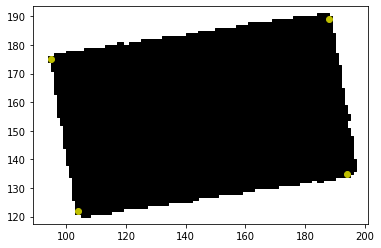

In [11]:
# Choose which glacier BoxID to check:
for BOI_ID in BoxIDs:
    if BOI_ID == '277':
        print(BOI_ID)
        # plot the raster pixels in black
        plt.scatter(boxes_xcoords[BOI_ID], boxes_ycoords[BOI_ID], c='k',marker='s')
        # plot the vertices
        plt.scatter(topleft_coords[BOI_ID][0], topleft_coords[BOI_ID][1], c='y')
        plt.scatter(bottomleft_coords[BOI_ID][0], bottomleft_coords[BOI_ID][1], c='y')
        plt.scatter(topright_coords[BOI_ID][0], topright_coords[BOI_ID][1], c='y')
        plt.scatter(bottomright_coords[BOI_ID][0], bottomright_coords[BOI_ID][1], c='y')
        # plot midpoints
        plt.scatter(total_df.at[BOI_ID,'lmid50_x'], total_df.at[BOI_ID,'lmid50_y'], c='m'); plt.scatter(total_df.at[BOI_ID, 'rmid50_x'], total_df.at[BOI_ID, 'rmid50_y'], c='m')
        plt.scatter(total_df.at[BOI_ID,'lmid25_x'], total_df.at[BOI_ID,'lmid25_y'], c='r'); plt.scatter(total_df.at[BOI_ID, 'rmid25_x'], total_df.at[BOI_ID, 'rmid25_y'], c='r')
        plt.scatter(total_df.at[BOI_ID,'lmid75_x'], total_df.at[BOI_ID,'lmid75_y'], c='b'); plt.scatter(total_df.at[BOI_ID, 'rmid75_x'], total_df.at[BOI_ID, 'rmid75_y'], c='b')
        # plot the centerlines in cyan
        x=np.linspace(np.min(boxes_xcoords[BOI_ID]), np.max(boxes_xcoords[BOI_ID])); y50=(total_df.at[BOI_ID, 'm50'])*x + (total_df.at[BOI_ID, 'b50']); 
        y25=(total_df.at[BOI_ID, 'm25'])*x + (total_df.at[BOI_ID, 'b25']); y75=(total_df.at[BOI_ID, 'm75'])*x + (total_df.at[BOI_ID, 'b75'])
        plt.plot(x, y50, '--m', x, y25, '--r', x, y75, '--b')
        # plot parameters      
        plt.gca().invert_yaxis(); plt.axis('scaled'); plt.show()

#### If successful, add these back to the full data table:

In [19]:
total_df = pd.concat([total_df, df2])

### Drop the right midpoints and write the centerline information to a csv

In [26]:
# total_df = total_df.drop(['rmid50_y', 'rmid25_y', 'rmid75_y'], axis=1)
total_df = total_df.drop(['295'])
total_df

,lmid50_x,lmid50_y,rmid50_x,m50,b50,lmid25_x,lmid25_y,rmid25_x,m25,b25,lmid75_x,lmid75_y,rmid75_x,m75,b75
BoxID,,,,,,,,,,,,,,,
229,84.5,99.5,147.5,0.587302,49.873016,92.25,85.75,155.25,0.587302,31.571429,76.75,113.25,139.75,0.587302,68.174603
235,114.5,147.0,224.0,0.132420,131.837900,116.25,133.00,225.50,0.135011,117.606164,112.75,161.00,222.50,0.129841,146.069635
247,140.0,229.0,238.0,-0.418367,287.571429,132.50,211.00,241.00,-0.419355,266.433673,147.50,247.00,235.00,-0.417143,308.709184
253,147.5,208.5,273.0,0.019920,205.561753,147.75,178.25,273.50,0.017893,175.306773,147.25,238.75,272.50,0.021956,235.816733
277,99.5,148.5,191.0,0.147541,133.819672,101.75,135.25,192.50,0.146006,120.237705,97.25,161.75,189.50,0.149051,147.401639


In [27]:
# change filename as desired
CLINE_NAME = 'Boxes_coords_pathrows_SE_2_v2.csv'
total_df.to_csv(path_or_buf = basepath+CLINE_NAME, sep=',')

# 2) Calculate terminus position time series

In [3]:
# IMPORT THE FUNCTION
os.chdir('/home/jukes/automated-glacier-terminus')
from automated_terminus_functions import results_allglaciers

(1925, 2)
Box229
(1423, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 158 dips
Dropping 139 dips
Dropping 207 dips
Dropping 117 jumps
Dropping 124 jumps
Dropping 260 jumps
93
75
122


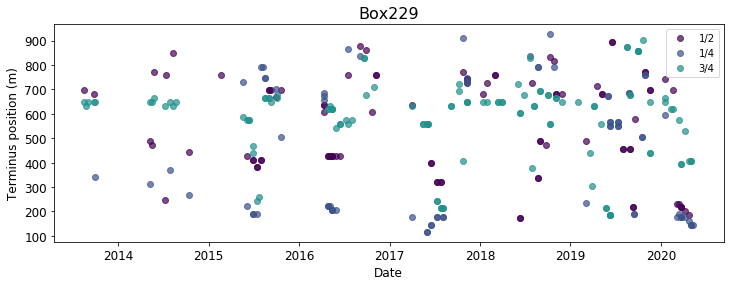

Box235
(1046, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 164 dips
Dropping 104 dips
Dropping 220 dips
Dropping 130 jumps
Dropping 96 jumps
Dropping 167 jumps
89
78
94


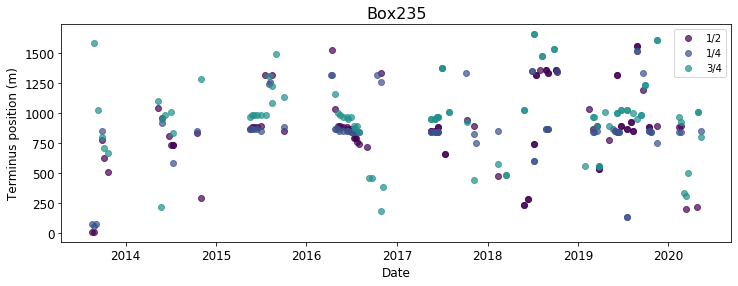

Box247
(622, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 11 dips
Dropping 5 dips
Dropping 35 dips
Dropping 56 jumps
Dropping 25 jumps
Dropping 31 jumps
81
71
72


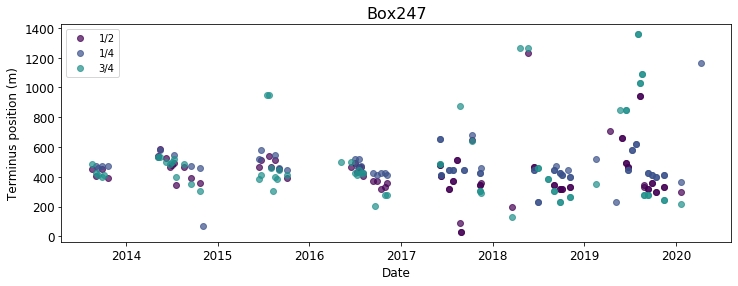

Box253
(700, 4)


/home/jukes/automated-glacier-terminus/automated_terminus_functions.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['changerate'] = tchange


Dropping 32 dips
Dropping 18 dips
Dropping 73 dips
Dropping 43 jumps
Dropping 25 jumps
Dropping 39 jumps
85
87
69


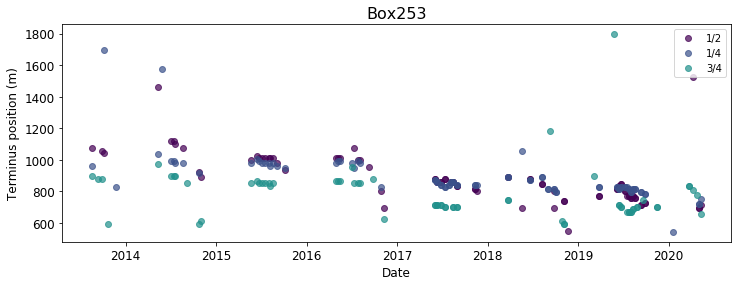

Box277


FileNotFoundError: [Errno 2] File /home/jukes/Documents/Sample_glaciers/terminuspicks_Box277_2020_07_06.csv does not exist: '/home/jukes/Documents/Sample_glaciers/terminuspicks_Box277_2020_07_06.csv'

In [28]:
# V is the flow speed scalar
# N1 is the number of iterations to remove dips
# N2 is the number of iterations to remove jumps
download = 'Images_downloaded_SE_2.csv'
imgdates = 'imgdates_SE_2.csv'
boxes_csv = 'Boxes_coords_pathrows_SE_2_v2.csv'
velocities = 'Glacier_vel_measures_SE_2.csv'
date = '2020_07_06'
V = 3
N1 = 1 
N2 = 1 

#run
results_allglaciers(download,imgdates, boxes_csv,velocities, date, V, N1, N2)